### **1. Visualize the normal and tumor training images**

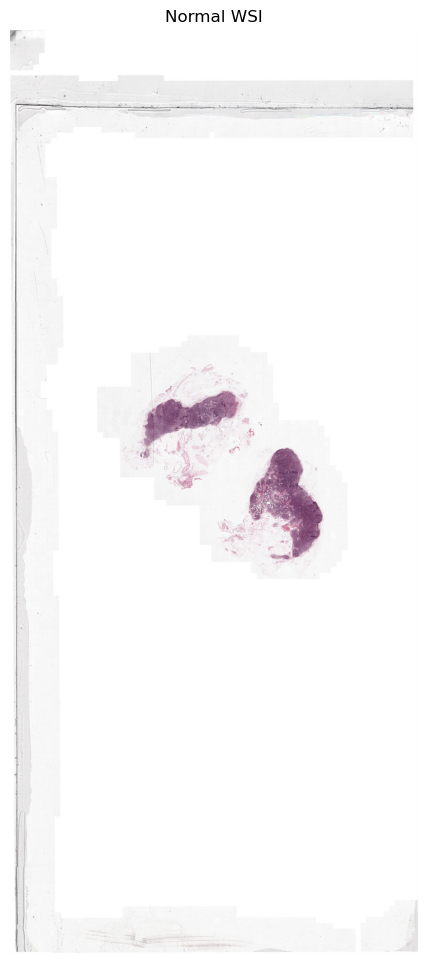

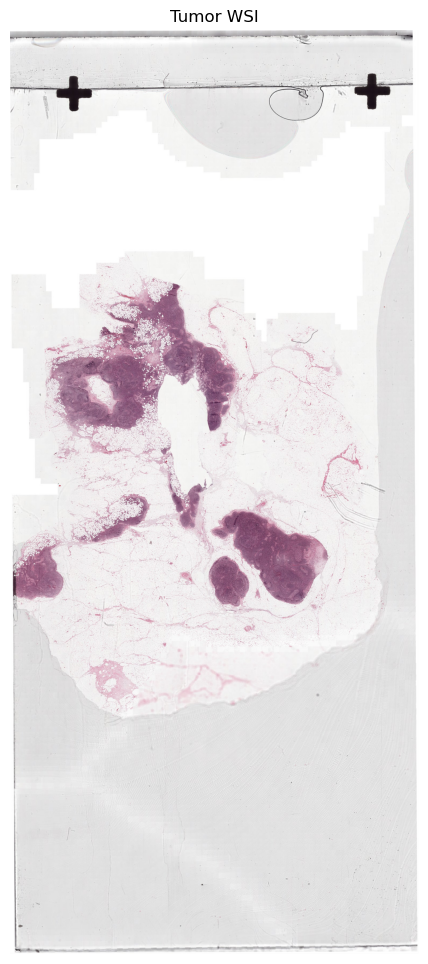

In [3]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import os

os.add_dll_directory(
    r"C:\Program Files\OpenSlide\openslide-bin-4.0.0.8-windows-x64\bin"
)

from openslide import OpenSlide


def show_wsi_thumbnail(wsi_path, thumbnail_size=(2048, 2048), title=""):
    slide = OpenSlide(wsi_path)
    thumbnail = slide.get_thumbnail(thumbnail_size)

    plt.figure(figsize=(12, 12))
    plt.imshow(thumbnail)
    plt.title(title)
    plt.axis("off")
    plt.show()


normal_path = os.path.join(
    os.getcwd(), "..", "data", "camelyon16", "train", "img", "normal_001.tif"
)
tumor_path = os.path.join(
    os.getcwd(), "..", "data", "camelyon16", "train", "img", "tumor_001.tif"
)

show_wsi_thumbnail(normal_path, title="Normal WSI")
show_wsi_thumbnail(tumor_path, title="Tumor WSI")

# Save thumbnails as PNG files
thumbnail_normal = (
    OpenSlide(normal_path).get_thumbnail((2048, 2048)).save("normal_thumbnail.png")
)
thumbnail_tumor = (
    OpenSlide(tumor_path).get_thumbnail((2048, 2048)).save("tumor_thumbnail.png")
)

In [ ]:
import zipfile


def extract_zip(zip_path, extract_to):
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)
    else:
        print(f"[INFO] Directory of destination already exists. Skipping extraction.")
        return
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extract_to)
    print(f"[INFO] Extracted {zip_path} to {extract_to}")


zip_path = os.path.join(
    os.getcwd(), "..", "data", "camelyon16", "masks", "lesion_annotations.zip"
)
extract_to = os.path.join(
    os.getcwd(), "..", "data", "camelyon16", "masks", "annotations"
)
extract_zip(zip_path, extract_to)

[INFO] Directory c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\masks\annotations already exists. Skipping extraction.


### **2. Overlaying the mask on the WSI**

In [ ]:
import numpy as np
import os
from openslide import OpenSlide
from lxml import etree
from PIL import Image, ImageDraw


def parse_xml_polygons(xml_path):
    """
    Parse XML and return a list of polygons (lists of (x, y) tuples).
    """
    tree = etree.parse(xml_path)
    polygons = []
    for region in tree.xpath("//Annotation/Coordinates | //Annotations/Annotation/Coordinates"):
        points = []
        for coord in region.xpath(".//Coordinate"):
            x = float(coord.attrib["X"])
            y = float(coord.attrib["Y"])
            points.append((x, y))
        if points:
            polygons.append(points)
    return polygons

def generate_binary_mask(wsi_path, xml_path, level=4, save_path="tumor_mask.png"):
    slide = OpenSlide(wsi_path)
    dims = slide.level_dimensions[level]
    downsample = slide.level_downsamples[level]

    print(f"[INFO] Slide size at level {level}: {dims}")
    print(f"[INFO] Downsample factor: {downsample}")

    # Create a blank (black) mask
    mask = Image.new("L", dims, 0)  # "L" for 8-bit grayscale
    draw = ImageDraw.Draw(mask)

    polygons = parse_xml_polygons(xml_path)

    for poly in polygons:
        # Downscale polygon coordinates to match the current level
        scaled_poly = [(x / downsample, y / downsample) for x, y in poly]
        draw.polygon(scaled_poly, outline=255, fill=255)

    mask.save(save_path)
    print(f"[INFO] Binary mask saved to: {save_path}")
    return mask

generate_binary_mask(
    wsi_path=tumor_path,
    xml_path=os.path.join(os.getcwd(), "..", "data", "camelyon16", "masks", "annotations", "tumor_001.xml"),
    level=4,
    save_path="tumor_001_mask.png"
);

[INFO] Slide size at level 4: (6112, 13824)
[INFO] Downsample factor: 16.0
[INFO] Binary mask saved to: tumor_001_mask.png


Processing slide: tumor_001
WSI path: c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\train\img\tumor_001.tif
XML path: c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\train\mask\annotations\tumor_001.xml
Thumbnail Level: 6, Dimensions: (1528, 3456), Downsample: 64.0
Thumbnail size: (1528, 3456)
Mask size: (1528, 3456)


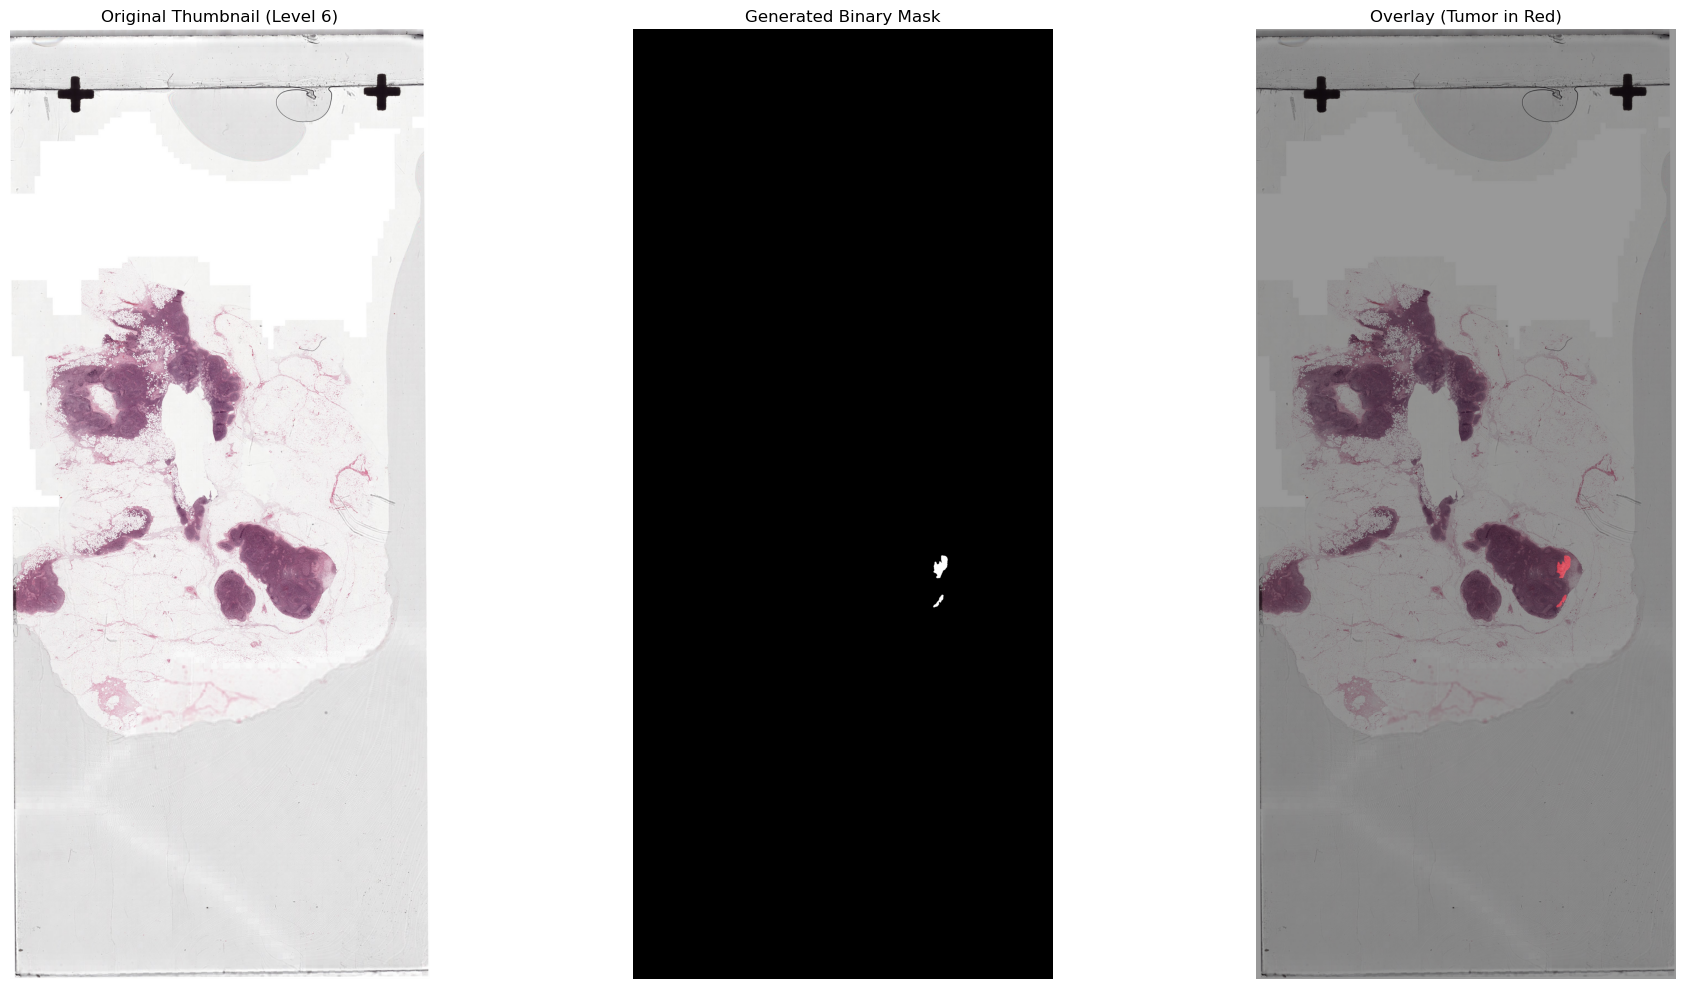

Visualization complete.


In [ ]:
import cv2

def parse_xml_mask(xml_path, level_dims, downsample):
    """
    Convert XML annotation to binary mask using a robust XPath for Camelyon16 structure.
    """
    try:
        tree = etree.parse(xml_path)
    except etree.XMLSyntaxError as e:
        print(f"Error parsing XML file {xml_path}: {e}")
        return None

    mask = Image.new("L", level_dims, 0)
    draw = ImageDraw.Draw(mask)

    for coordinates_node in tree.xpath("//Annotation/Coordinates | //Annotations/Annotation/Coordinates"):
        coords = []
        for coord_node in coordinates_node.findall("Coordinate"):
            try:
                x = float(coord_node.get("X"))
                y = float(coord_node.get("Y"))
                # Scale coordinates to the target level
                scaled_x = int(x / downsample)
                scaled_y = int(y / downsample)
                coords.append((scaled_x, scaled_y))
            except (ValueError, TypeError) as e:
                print(f"Warning: Could not parse coordinate (X,Y) from XML for {xml_path}: {e}")
                continue
        if coords:
            # Draw with 255 for white on a black background
            draw.polygon(coords, outline=255, fill=255)
    return mask

def visualize_mask_and_thumbnail(slide_id="tumor_001", level=6):
    wsi_dir = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img")
    annot_dir = os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "mask", "annotations") 

    wsi_filename = f"{slide_id}.tif"
    xml_filename = f"{slide_id}.xml"

    wsi_path = os.path.join(wsi_dir, wsi_filename)
    xml_path = os.path.join(annot_dir, xml_filename)

    if not os.path.exists(wsi_path):
        print(f"Error: WSI not found at {wsi_path}")
        return
    if not os.path.exists(xml_path):
        print(f"Error: XML annotation not found at {xml_path}. This slide might be a normal one or the path is incorrect.")
        return

    try:
        slide = openslide.OpenSlide(wsi_path)
    except openslide.OpenSlideError as e:
        print(f"Error opening WSI {wsi_path}: {e}")
        return

    if level >= slide.level_count:
        print(f"Error: Level {level} is too high for this slide. Max level is {slide.level_count - 1}.")
        slide.close()
        return

    level_dims = slide.level_dimensions[level]
    downsample = slide.level_downsamples[level]

    print(f"Processing slide: {slide_id}")
    print(f"WSI path: {wsi_path}")
    print(f"XML path: {xml_path}")
    print(f"Thumbnail Level: {level}, Dimensions: {level_dims}, Downsample: {downsample}")

    thumbnail = slide.read_region((0, 0), level, level_dims).convert("RGB")
    print(f"Thumbnail size: {thumbnail.size}")

    mask = parse_xml_mask(xml_path, level_dims, downsample)
    if mask is None:
        print("Mask generation failed. Exiting visualization.")
        slide.close()
        return

    print(f"Mask size: {mask.size}")

    # Convert mask to a colored overlay for better visualization
    mask_np = np.array(mask)
    colored_mask = np.zeros((*mask_np.shape, 3), dtype=np.uint8)
    colored_mask[mask_np == 255] = [255, 0, 0] # Red color for tumor regions (since fill=255)

    thumbnail_np = np.array(thumbnail)

    # Use cv2.addWeighted for blending if available, otherwise numpy fallback
    if 'cv2' in globals() and hasattr(cv2, 'addWeighted'):
        overlay = Image.fromarray(cv2.addWeighted(thumbnail_np, 0.6, colored_mask, 0.4, 0)) # Thumbnail 60%, Red Mask 40%
    else:
        # Fallback blending (simple average, less visually appealing than addWeighted but works)
        alpha = 0.4
        overlay_np = (thumbnail_np * (1 - alpha) + colored_mask * alpha).astype(np.uint8)
        overlay = Image.fromarray(overlay_np)


    fig, axes = plt.subplots(1, 3, figsize=(20, 10))

    axes[0].imshow(thumbnail)
    axes[0].set_title(f'Original Thumbnail (Level {level})')
    axes[0].axis('off')

    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Generated Binary Mask')
    axes[1].axis('off')

    axes[2].imshow(overlay)
    axes[2].set_title(f'Overlay (Tumor in Red)')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

    slide.close()
    print("Visualization complete.")

visualize_mask_and_thumbnail(slide_id="tumor_001", level=6)

In [23]:
parse_xml_mask(
    xml_path=os.path.join(os.getcwd(), "..", "data", "camelyon16", "masks", "annotations", "tumor_001.xml"),
    level_dims=(2048, 2048),
    downsample=32
);

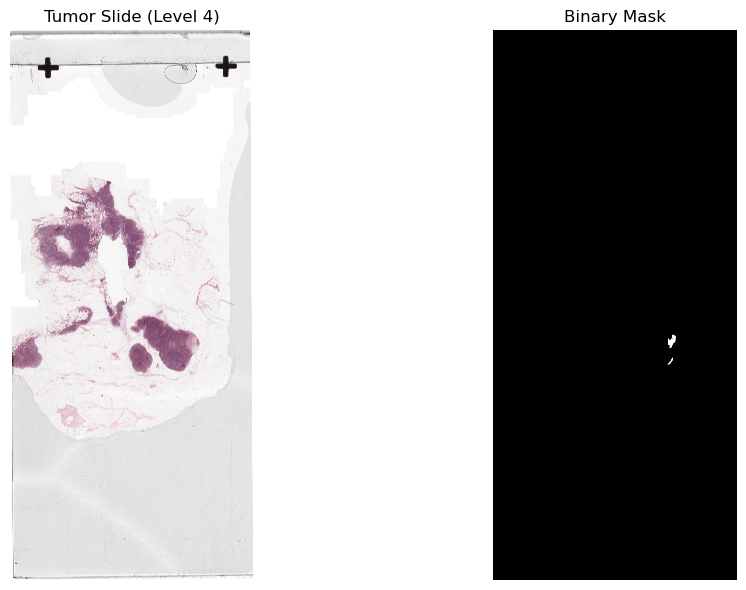

In [ ]:
# Show for level 4
mask = Image.open("tumor_mask.png")
slide = OpenSlide(wsi_path)
thumb = slide.read_region((0, 0), level=4, size=slide.level_dimensions[4]).convert("RGB")

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(thumb)
ax[0].set_title("Tumor Slide (Level 4)")
ax[0].axis("off")

ax[1].imshow(mask, cmap='gray')
ax[1].set_title("Binary Mask")
ax[1].axis("off")

plt.tight_layout()
plt.show()


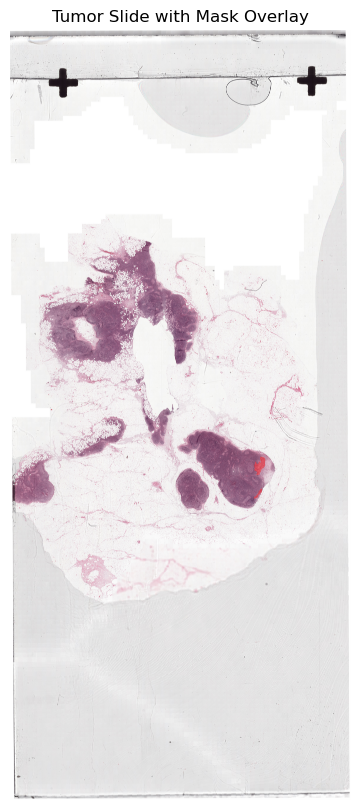

In [ ]:
def show_overlay(wsi_path, mask_path, level=4, alpha=0.4): # Shows overlay for level 4a
    slide = OpenSlide(wsi_path)
    dims = slide.level_dimensions[level]
    wsi_img = slide.read_region((0, 0), level, dims).convert("RGB")

    mask = Image.open(mask_path).convert("L")
    mask = mask.resize(wsi_img.size) 
    wsi_np = np.array(wsi_img)
    mask_np = np.array(mask)

    # Create red mask overlay
    red_overlay = np.zeros_like(wsi_np)
    red_overlay[..., 0] = 255  # red channel

    # Blend the red mask where mask is present
    blended = np.where(mask_np[..., None] > 0,
                       (1 - alpha) * wsi_np + alpha * red_overlay,
                       wsi_np).astype(np.uint8)

    # Show the result
    plt.figure(figsize=(10, 10))
    plt.imshow(blended)
    plt.axis("off")
    plt.title("Tumor Slide with Mask Overlay")
    plt.show()

show_overlay(
    wsi_path=tumor_path,
    mask_path="tumor_mask.png",
    level=4,
    alpha=0.4
)

## **Convert mask and images to tensor**

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

# Define transformations for images and masks
image_transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert image to tensor
        transforms.Resize((512, 512)),  # Resize to a fixed size
    ]
)

mask_transform = transforms.Compose(
    [
        transforms.ToTensor(),  # Convert mask to tensor
        transforms.Resize((512, 512)),  # Resize to match image size
        transforms.Lambda(lambda x: (x > 0).float()),  # Convert mask to binary (0 or 1)
    ]
)


def preprocess_image(image_path, transform):
    image = Image.open(image_path)
    return transform(image)


def preprocess_mask(mask_path, transform):
    mask = Image.open(mask_path)
    return transform(mask)

In [ ]:
from torch.utils.data import Dataset


class CamelyonDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith(".tif")]
        self.mask_files = [
            f.replace(".tif", ".png") for f in self.image_files
        ]  # Assuming masks are PNG files

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_files[idx])
        image = preprocess_image(image_path, self.image_transform)
        mask = preprocess_mask(mask_path, self.mask_transform)
        return image, mask

In [ ]:
from torch.utils.data import DataLoader

train_image_dir = "./data/camelyon16/train/img"
train_mask_dir = "./data/camelyon16/masks"

train_dataset = CamelyonDataset(
    train_image_dir, train_mask_dir, image_transform, mask_transform
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Test the dataloader
for images, masks in train_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")
    break

In [ ]:
# Size in bytes of normal_002.tif (width and height)
normal_path = os.path.join(
    os.getcwd(), "..", "data", "camelyon16", "train", "img", "normal_005.tif"
)
width, height = OpenSlide(normal_path).dimensions
print(f"Normal WSI dimensions: {width}x{height}")
normal_size = os.path.getsize(normal_path)
normal_size

# find biggest WSI in the training set
import glob

wsi_files = glob.glob(
    os.path.join(
        os.path.join(os.getcwd(), "..", "data", "camelyon16", "train", "img"), "*.tif"
    )
)
biggest_wsi = max(wsi_files, key=os.path.getsize)
biggest_wsi_size = os.path.getsize(biggest_wsi)
print(f"Biggest WSI: {biggest_wsi}, Size: {biggest_wsi_size} bytes")
# measure the size in bytes of tumor_001.tif (width and height)
width, height = OpenSlide(tumor_path).dimensions
print(f"Tumor WSI dimensions: {width}x{height}")

Normal WSI dimensions: 97792x221184
Biggest WSI: c:\Users\anaca\Documents\sexto.curso\tfg info\fresh-clone\ss25_Hierarchical_Multiscale_Image_Classification\src\..\data\camelyon16\train\img\tumor_001.tif, Size: 3264779514 bytes
Tumor WSI dimensions: 97792x221184
